In [1]:
#Import the necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy import stats

In [154]:
#Read the data

data=pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
data.head()

year                                         track_name  track_popularity  \
0  2000                                             7 Days                73   
1  2000           Absolutely (Story of a Girl) - Radio Mix                69   
2  2000  Against All Odds (Take A Look at Me Now) - Mar...                61   
3  2000                               All The Small Things                84   
4  2000                                             Amazed                72   

                                         album   artist_name  \
0                                Born to Do It   Craig David   
1                            The Madding Crowd     Nine Days   
2  Against All Odds (Take A Look at Me Now) EP  Mariah Carey   
3                           Enema Of The State     blink-182   
4                                 Lonely Grill      Lonestar   

                                       artist_genres  artist_popularity  \
0                                   ['british soul']                 62   
1                                       ['pop rock']                 49   
2         ['dance pop'; 'pop'; 'urban contemporary']                 76   
3  ['alternative metal'; 'modern rock'; 'pop punk...                 75   
4  ['contemporary country'; 'country'; 'country r...                 57   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.659   0.812  4.0      87.0   0.0       0.0487      0.230000   
1         0.481   0.940  7.0      71.0   1.0       0.0660      0.000891   
2         0.542   0.498  1.0      80.0   1.0       0.0299      0.490000   
3         0.434   0.897  0.0      69.0   1.0       0.0488      0.010300   
4         0.561   0.543  1.0      92.0   1.0       0.0324      0.260000   

   instrumentalness  liveness  valence    tempo  duration_ms  
0               0.0    0.0951    0.888   83.014     235133.0  
1               0.0    0.0939    0.660   96.493     189333.0  
2               0.0    0.1010    0.218  117.763     201933.0  
3               0.0    0.6120    0.684  148.726     167067.0  
4               0.0    0.1240    0.243  139.803     240867.0

In [155]:
data.shape

(2300, 19)

In [156]:
#Percentage of missing values in each row
data.isna().mean()*100

year                 0.000000
track_name           0.000000
track_popularity     0.000000
album                0.000000
artist_name          0.000000
artist_genres        0.000000
artist_popularity    0.000000
danceability         0.043478
energy               0.043478
key                  0.043478
loudness             0.043478
mode                 0.043478
speechiness          0.043478
acousticness         0.043478
instrumentalness     0.043478
liveness             0.043478
valence              0.043478
tempo                0.043478
duration_ms          0.043478
dtype: float64

Seems like there's the same number of missing values. Being less than 0.5%, we can just drop them

In [157]:
data.dropna(inplace=True)

In [6]:
#Function to include median, mode, kurtosis, skewness and type of variable

def describex(data):
    data = pd.DataFrame(data)
    stats = pd.DataFrame(data.describe(include='all'))

    median = data.select_dtypes(include=[np.number]).median()
    md=pd.DataFrame(index=data.columns)
    md['median'] = median.reindex(data.columns).fillna('N/A')

    mode=pd.DataFrame(data.select_dtypes(include=[np.number]).mode().loc[0])
    mo=pd.DataFrame(index=data.columns)
    mo['mode']= mode.reindex(data.columns).fillna('N/A')

    inter=pd.DataFrame(data.select_dtypes(include=[np.number]).quantile(0.75)-data.select_dtypes(include=[np.number]).quantile(0.25))
    iqr=pd.DataFrame(index=data.columns)
    iqr['IQR'] = inter.reindex(data.columns).fillna('N/A')

    rang=pd.DataFrame(data.select_dtypes(include=[np.number]).max()-data.select_dtypes(include=[np.number]).min())
    ran=pd.DataFrame(index=data.columns)
    ran['range'] = rang.reindex(data.columns).fillna('N/A')    

    skewness = data.select_dtypes(include=[np.number]).skew()
    rs = pd.DataFrame(index=data.columns)
    rs['skewness'] = skewness.reindex(data.columns).fillna('N/A')

    kurtosis = data.select_dtypes(include=[np.number]).kurtosis()
    rk = pd.DataFrame(index=data.columns)
    rk['kurtosis'] = kurtosis.reindex(data.columns).fillna('N/A')

    types=pd.DataFrame(data.dtypes, columns=['type']).map(lambda x: 'numerical' if x=='int64' or x=='float64' else 'categorical')
    types=types.T

    skewness_df = rs.T
    kurtosis_df = rk.T
    median_df = md.T
    mode_df = mo.T
    iqr_df = iqr.T
    rang_df = ran.T

    stats=pd.concat([stats.iloc[:5], median_df, mode_df, stats.iloc[5:]], ignore_index=False)
    stats=pd.concat([stats.iloc[:13], iqr_df, rang_df, stats.iloc[13:]], ignore_index=False)
    stats=pd.concat([stats, kurtosis_df, skewness_df, types], ignore_index=False)
    
    return stats

In [7]:
describex(data)

year   track_name track_popularity        album  artist_name  \
count          2299.0         2299           2299.0         2299         2299   
unique            NaN         2120              NaN         1663          891   
top               NaN         Home              NaN    18 Months        Drake   
freq              NaN            5              NaN            8           32   
mean      2011.003045          NaN        70.944759          NaN          NaN   
median         2011.0          N/A             72.0          N/A          N/A   
mode           2000.0          N/A             73.0          N/A          N/A   
std          6.634528          NaN        12.294047          NaN          NaN   
min            2000.0          NaN              0.0          NaN          NaN   
25%            2005.0          NaN             66.0          NaN          NaN   
50%            2011.0          NaN             72.0          NaN          NaN   
75%            2017.0          NaN             79.0          NaN          NaN   
max            2022.0          NaN            100.0          NaN          NaN   
IQR              12.0          N/A             13.0          N/A          N/A   
range            22.0          N/A            100.0          N/A          N/A   
kurtosis    -1.204134          N/A        10.358751          N/A          N/A   
skewness    -0.000866          N/A        -2.341099          N/A          N/A   
type        numerical  categorical        numerical  categorical  categorical   

         artist_genres artist_popularity danceability     energy        key  \
count             2299            2299.0       2299.0     2299.0     2299.0   
unique             698               NaN          NaN        NaN        NaN   
top            ['pop']               NaN          NaN        NaN        NaN   
freq               135               NaN          NaN        NaN        NaN   
mean               NaN         72.873423     0.660116   0.693047   5.277947   
median             N/A              74.0        0.671      0.712        5.0   
mode               N/A              87.0        0.687      0.862        1.0   
std                NaN         12.180506     0.141137   0.164838   3.628494   
min                NaN              29.0        0.162     0.0519        0.0   
25%                NaN              65.0        0.572      0.586        2.0   
50%                NaN              74.0        0.671      0.712        5.0   
75%                NaN              82.0       0.7595       0.82        8.0   
max                NaN             100.0        0.975      0.999       11.0   
IQR                N/A              17.0       0.1875      0.234        6.0   
range              N/A              71.0        0.813     0.9471       11.0   
kurtosis           N/A         -0.059094    -0.015515   0.170401   -1.30484   
skewness           N/A         -0.409799    -0.398012  -0.630005   0.023334   
type       categorical         numerical    numerical  numerical  numerical   

           loudness       mode speechiness acousticness instrumentalness  \
count        2299.0     2299.0      2299.0       2299.0           2299.0   
unique          NaN        NaN         NaN          NaN              NaN   
top             NaN        NaN         NaN          NaN              NaN   
freq            NaN        NaN         NaN          NaN              NaN   
mean       73.00696   0.598521    0.097795     0.157689         0.013766   
median         74.0        1.0      0.0568       0.0689              0.0   
mode           70.0        1.0      0.0338        0.107              0.0   
std       15.643937   0.490304    0.092445     0.203844          0.08399   
min           -56.0        0.0      0.0225     0.000013              0.0   
25%            63.0        0.0       0.038       0.0165              0.0   
50%            74.0        1.0      0.0568       0.0689              0.0   
75%            83.0        1.0      0.1155        0.223        

There seems to be something weird with instrumentalness. Upon manual inspection and statistics review, it looks like the dataset contains mainly values very close to zero and only a handful of values above 0.1. Given this, we will remove it from the dataset

In [158]:
data=data.drop('instrumentalness', axis=1)

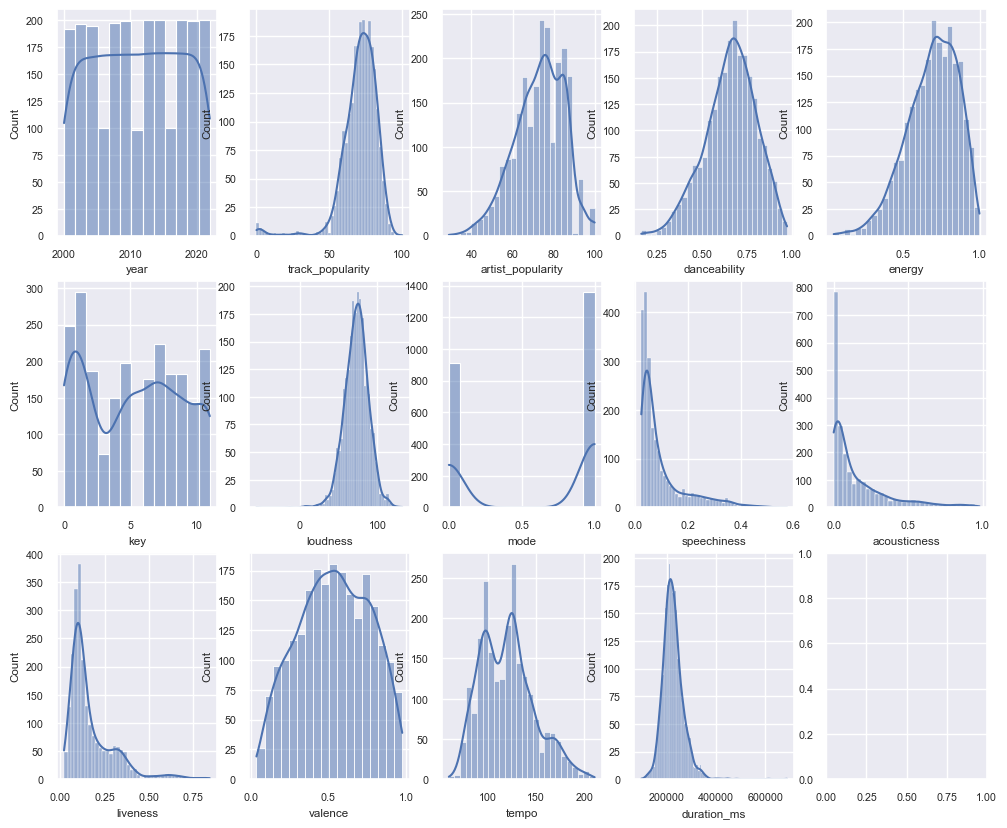

In [207]:
#Visualizar las variables continuas
def plot_ghraphs(data:pd.DataFrame, rows:int, cols:int, font_scale:float):
    # df=data[data]
    fig, axes = plt.subplots(rows,cols, figsize=(12,10))
    axes = axes.flatten()

    sns.set_theme(font_scale=font_scale)

    i=0
    for col in data.columns:
        if data[col].dtype=='int64' or data[col].dtype=='float64':
            sns.histplot(data[col], ax=axes[i], kde=True)
            i+=1
        # elif data[col].dtype=='object':
        #     axes[i].pie(data[col].value_counts(),labels=data[col].astype(str).unique(), autopct=lambda p: f'{int(p * sum(data[col].value_counts()) / 100)}')

    plt.show()

plot_ghraphs(data, 3,5,0.7)

Now we have to deal with the categorical values. There are three options: creating dummy variables (which seems counterproductive given that there are too many different values for album, artist, genres, etc.), encode each categorical variable, or dropping them from the analysis.

In [159]:
categorical=[i for i in data.dtypes[data.dtypes=='object'].index]
categorical


['track_name', 'album', 'artist_name', 'artist_genres']

In [160]:
import ast

def parse_list_string(s):
    s = s.strip("[]")  # Remove the surrounding brackets
    return [item.strip().strip("'") for item in s.split(";")] if s else []

In [ ]:
#Get a list of genres instead of a string of list
data['artist_genres']=data['artist_genres'].apply(parse_list_string)


In [ ]:
#Find songs in which genre is empty to avoid errors

data[data['artist_genres'].apply(lambda x: x==[''] or x==[])].count()

year                 24
track_name           24
track_popularity     24
album                24
artist_name          24
artist_genres        24
artist_popularity    24
danceability         24
energy               24
key                  24
loudness             24
mode                 24
speechiness          24
acousticness         24
liveness             24
valence              24
tempo                24
duration_ms          24
dtype: int64

In [ ]:
#Filter out those songs with empty genre
data=data[~data['artist_genres'].apply(lambda x: x==[''] or x==[])]
data

year                                         track_name  \
0     2000                                             7 Days   
1     2000           Absolutely (Story of a Girl) - Radio Mix   
2     2000  Against All Odds (Take A Look at Me Now) - Mar...   
3     2000                               All The Small Things   
4     2000                                             Amazed   
...    ...                                                ...   
2295  2022                          We Don't Talk About Bruno   
2296  2022                                   When You're Gone   
2297  2022                                  Where Are You Now   
2298  2022                                              Woman   
2299  2022                                        Yet To Come   

      track_popularity                                         album  \
0                   73                                 Born to Do It   
1                   69                             The Madding Crowd   
2                   61   Against All Odds (Take A Look at Me Now) EP   
3                   84                            Enema Of The State   
4                   72                                  Lonely Grill   
...                ...                                           ...   
2295                77  Encanto (Original Motion Picture Soundtrack)   
2296                78                              When You're Gone   
2297                87                             Where Are You Now   
2298                87                                    Planet Her   
2299                76                                         Proof   

                      artist_name  \
0                     Craig David   
1                       Nine Days   
2                    Mariah Carey   
3                       blink-182   
4                        Lonestar   
...                           ...   
2295  Carolina GaitÃ¡n - La Gaita   
2296                 Shawn Mendes   
2297             Lost Frequencies   
2298                     Doja Cat   
2299                          BTS   

                                          artist_genres  artist_popularity  \
0                                        [british soul]                 62   
1                                            [pop rock]                 49   
2                  [dance pop, pop, urban contemporary]                 76   
3     [alternative metal, modern rock, pop punk, pun...                 75   
4         [contemporary country, country, country road]                 57   
...                                                 ...                ...   
2295                                      [movie tunes]                 56   
2296                     [canadian pop, pop, viral pop]                 81   
2297      [belgian edm, edm, pop dance, tropical house]                 76   
2298                                   [dance pop, pop]                 86   
2299                      [k-pop, k-pop boy group, pop]                 87   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.659   0.812  4.0      87.0   0.0       0.0487      0.230000   
1            0.481   0.940  7.0      71.0   1.0       0.0660      0.000891   
2            0.542   0.498  1.0      80.0   1.0       0.0299      0.490000   
3            0.434   0.897  0.0      69.0   1.0       0.0488      0.010300   
4            0.561   0.543  1.0      92.0   1.0       0.0324      0.260000   
...            ...     ...  ...       ...   ...          ...           ...   
2295         0.577   0.450  0.0      93.0   0.0       0.0834      0.357000   
2296         0.603   0.691  5.0      76.0   1.0       0.0372      0.024800   
2297         0.671   0.636  6.0      90.0   0.0       0.1030      0.515000   
2298         0.824   0.764  5.0      62.0   0.0       0.0854      0.088800   
2299         0.559   0.885  1.0      65.0   1.0       0.1890      0.043200   

      liveness  valence    tempo  duratio

In [ ]:
# Now only keep the first genre of the list as te most representative one
data['artist_genres']=data['artist_genres'].apply(lambda x: x[0])

In [187]:
data

year                                         track_name  \
0     2000                                             7 Days   
1     2000           Absolutely (Story of a Girl) - Radio Mix   
2     2000  Against All Odds (Take A Look at Me Now) - Mar...   
3     2000                               All The Small Things   
4     2000                                             Amazed   
...    ...                                                ...   
2295  2022                          We Don't Talk About Bruno   
2296  2022                                   When You're Gone   
2297  2022                                  Where Are You Now   
2298  2022                                              Woman   
2299  2022                                        Yet To Come   

      track_popularity                                         album  \
0                   73                                 Born to Do It   
1                   69                             The Madding Crowd   
2                   61   Against All Odds (Take A Look at Me Now) EP   
3                   84                            Enema Of The State   
4                   72                                  Lonely Grill   
...                ...                                           ...   
2295                77  Encanto (Original Motion Picture Soundtrack)   
2296                78                              When You're Gone   
2297                87                             Where Are You Now   
2298                87                                    Planet Her   
2299                76                                         Proof   

                      artist_name         artist_genres  artist_popularity  \
0                     Craig David          british soul                 62   
1                       Nine Days              pop rock                 49   
2                    Mariah Carey             dance pop                 76   
3                       blink-182     alternative metal                 75   
4                        Lonestar  contemporary country                 57   
...                           ...                   ...                ...   
2295  Carolina GaitÃ¡n - La Gaita           movie tunes                 56   
2296                 Shawn Mendes          canadian pop                 81   
2297             Lost Frequencies           belgian edm                 76   
2298                     Doja Cat             dance pop                 86   
2299                          BTS                 k-pop                 87   

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.659   0.812  4.0      87.0   0.0       0.0487      0.230000   
1            0.481   0.940  7.0      71.0   1.0       0.0660      0.000891   
2            0.542   0.498  1.0      80.0   1.0       0.0299      0.490000   
3            0.434   0.897  0.0      69.0   1.0       0.0488      0.010300   
4            0.561   0.543  1.0      92.0   1.0       0.0324      0.260000   
...            ...     ...  ...       ...   ...          ...           ...   
2295         0.577   0.450  0.0      93.0   0.0       0.0834      0.357000   
2296         0.603   0.691  5.0      76.0   1.0       0.0372      0.024800   
2297         0.671   0.636  6.0      90.0   0.0       0.1030      0.515000   
2298         0.824   0.764  5.0      62.0   0.0       0.0854      0.088800   
2299         0.559   0.885  1.0      65.0   1.0       0.1890      0.043200   

      liveness  valence    tempo  duration_ms broad_genre  
0       0.0951    0.888   83.014     235133.0       Other  
1       0.0939    0.660   96.493     189333.0       Other  
2       0.1010    0.218  117.763     201933.0       Other  
3       0.6120    0.684  148.726     167067.0       Other  
4       0.1240    0.243  139.803     240867.0       Other  
...        ...      ...      ...          ...         ...  
2295    0.1110    0.830  205.863     216120.0       Other  
2296  

In [192]:
# Still need to reduce and group them as we have many categories

genre_mapping = {
    "Pop": [
        "dance pop", "pop", "canadian pop", "britpop", "electropop", "art pop",
        "pop rock", "pop soul", "pop dance", "indie pop", "neo mellow",
        "puerto rican pop", "acoustic pop", "irish pop", "danish pop",
        "dutch pop", "australian pop", "romanian pop", "gauze pop", "vocal house",
        "electropowerpop", "broadway", "belgian pop", "glee club"
    ],
    "Hip-Hop & Rap": [
        "atl hip hop", "pop rap", "hip hop", "chicago rap", "conscious hip hop",
        "battle rap", "gangster rap", "trap", "emo rap", "kentucky hip hop",
        "canadian hip hop", "bronx hip hop", "uk hip hop", "brooklyn drill",
        "memphis hip hop", "houston rap", "detroit hip hop", "florida drill",
        "new jersey rap", "san diego rap", "birmingham hip hop", "dfw rap",
        "argentine hip hop", "baton rouge rap", "ohio hip hop", "rap rock",
        "viral rap", "deep underground hip hop", "uk contemporary r&b",
        "uk garage", "rap kreyol", "comic", "asian american hip hop",
        "australian hip hop", "k-rap"
    ],
    "Rock & Alternative": [
        "alternative metal", "alternative rock", "indie rock", "modern rock",
        "emo", "garage rock", "glam rock", "british alternative rock",
        "british singer-songwriter", "icelandic indie", "irish rock",
        "celtic rock", "israeli pop", "hawaiian hip hop", "australian indie",
        "birmingham hip hop", "modern alternative rock", "modern alternative pop",
        "rock-and-roll", "album rock", "new wave pop", "dance-punk",
        "alternative dance", "alternative pop rock", "modern blues rock",
        "australian alternative rock", "indie rock italiano", "english indie rock"
    ],
    "Electronic & Dance": [
        "edm", "electropop", "big room", "dutch house", "bubblegum dance",
        "eurodance", "electro", "dance rock", "trance", "deep euro house",
        "electro house", "dutch edm", "dancehall", "hardcore hip hop",
        "electropowerpop", "filter house", "german dance", "bouncy house",
        "dancefloor dnb", "disco house", "belgian dance", "dance-punk",
        "new french touch", "big beat", "techno", "house", "bass house",
        "acid house", "uk garage", "brostep", "cloud rap", "electronica",
        "dance pop", "complextro"
    ],
    "R&B & Soul": [
        "contemporary r&b", "r&b", "neo soul", "afro r&b", "funk pop",
        "british soul", "canadian contemporary r&b", "hip pop", "neo-singer-songwriter",
        "melodic rap", "singer-songwriter pop", "slowed and reverb"
    ],
    "Latin": [
        "reggaeton", "latin pop", "latin hip hop", "colombian pop", "canadian latin",
        "mambo chileno", "latin arena pop", "sertanejo", "brazilian funk"
    ],
    "Country & Folk": [
        "contemporary country", "country", "folk-pop", "indie anthem-folk",
        "modern folk rock", "celtic", "stomp and holler", "classic oklahoma country"
    ],
    "Indie & Singer-Songwriter": [
        "indie pop", "indie pop rap", "indie poptimism", "indietronica",
        "alternative hip hop", "gen z singer-songwriter", "neo mellow"
    ],
    "Jazz & Classic": [
        "contemporary vocal jazz", "jazz", "classic rock", "classic schlager",
        "classic house", "modern folk rock", "adult standards"
    ],
    "Regional & World": [
        "k-pop", "idol", "australian dance", "australian psych",
        "norwegian hip hop", "german pop", "french indie pop", "french shoegaze",
        "afrofuturism", "afrobeats", "soca", "chicano rap", "bhangra",
        "filmi", "belgian edm", "gospel", "hawaiian hip hop", "movie tunes",
        "viral pop", "viral trap", "viral rap"
    ]
}

# Reverse the dictionary for mapping
genre_reverse_map = {genre: broad_category for broad_category, genres in genre_mapping.items() for genre in genres}

data['broad_genre'] = data['artist_genres'].apply(lambda x: genre_reverse_map.get(x, 'Other'))

In [194]:
data['broad_genre'].value_counts()

broad_genre
Electronic & Dance           587
Pop                          400
Hip-Hop & Rap                360
Other                        334
Rock & Alternative           192
R&B & Soul                   158
Indie & Singer-Songwriter     73
Latin                         55
Regional & World              54
Country & Folk                50
Jazz & Classic                12
Name: count, dtype: int64

In [196]:
data.drop(categorical, axis=1, inplace=True)
data

year  track_popularity  artist_popularity  danceability  energy  key  \
0     2000                73                 62         0.659   0.812  4.0   
1     2000                69                 49         0.481   0.940  7.0   
2     2000                61                 76         0.542   0.498  1.0   
3     2000                84                 75         0.434   0.897  0.0   
4     2000                72                 57         0.561   0.543  1.0   
...    ...               ...                ...           ...     ...  ...   
2295  2022                77                 56         0.577   0.450  0.0   
2296  2022                78                 81         0.603   0.691  5.0   
2297  2022                87                 76         0.671   0.636  6.0   
2298  2022                87                 86         0.824   0.764  5.0   
2299  2022                76                 87         0.559   0.885  1.0   

      loudness  mode  speechiness  acousticness  liveness  valence    tempo  \
0         87.0   0.0       0.0487      0.230000    0.0951    0.888   83.014   
1         71.0   1.0       0.0660      0.000891    0.0939    0.660   96.493   
2         80.0   1.0       0.0299      0.490000    0.1010    0.218  117.763   
3         69.0   1.0       0.0488      0.010300    0.6120    0.684  148.726   
4         92.0   1.0       0.0324      0.260000    0.1240    0.243  139.803   
...        ...   ...          ...           ...       ...      ...      ...   
2295      93.0   0.0       0.0834      0.357000    0.1110    0.830  205.863   
2296      76.0   1.0       0.0372      0.024800    0.5830    0.577  147.148   
2297      90.0   0.0       0.1030      0.515000    0.1720    0.262  120.966   
2298      62.0   0.0       0.0854      0.088800    0.1170    0.881  107.998   
2299      65.0   1.0       0.1890      0.043200    0.3330    0.683  172.029   

      duration_ms         broad_genre  
0        235133.0          R&B & Soul  
1        189333.0                 Pop  
2        201933.0  Electronic & Dance  
3        167067.0  Rock & Alternative  
4        240867.0      Country & Folk  
...           ...                 ...  
2295     216120.0    Regional & World  
2296     172267.0                 Pop  
2297     148197.0    Regional & World  
2298     172627.0  Electronic & Dance  
2299     193594.0    Regional & World  

[2275 rows x 15 columns]

In [197]:
data=pd.get_dummies(data, columns=['broad_genre'],drop_first=True)
data

year  track_popularity  artist_popularity  danceability  energy  key  \
0     2000                73                 62         0.659   0.812  4.0   
1     2000                69                 49         0.481   0.940  7.0   
2     2000                61                 76         0.542   0.498  1.0   
3     2000                84                 75         0.434   0.897  0.0   
4     2000                72                 57         0.561   0.543  1.0   
...    ...               ...                ...           ...     ...  ...   
2295  2022                77                 56         0.577   0.450  0.0   
2296  2022                78                 81         0.603   0.691  5.0   
2297  2022                87                 76         0.671   0.636  6.0   
2298  2022                87                 86         0.824   0.764  5.0   
2299  2022                76                 87         0.559   0.885  1.0   

      loudness  mode  speechiness  acousticness  ...  \
0         87.0   0.0       0.0487      0.230000  ...   
1         71.0   1.0       0.0660      0.000891  ...   
2         80.0   1.0       0.0299      0.490000  ...   
3         69.0   1.0       0.0488      0.010300  ...   
4         92.0   1.0       0.0324      0.260000  ...   
...        ...   ...          ...           ...  ...   
2295      93.0   0.0       0.0834      0.357000  ...   
2296      76.0   1.0       0.0372      0.024800  ...   
2297      90.0   0.0       0.1030      0.515000  ...   
2298      62.0   0.0       0.0854      0.088800  ...   
2299      65.0   1.0       0.1890      0.043200  ...   

      broad_genre_Electronic & Dance  broad_genre_Hip-Hop & Rap  \
0                              False                      False   
1                              False                      False   
2                               True                      False   
3                              False                      False   
4                              False                      False   
...                              ...                        ...   
2295                           False                      False   
2296                           False                      False   
2297                           False                      False   
2298                            True                      False   
2299                           False                      False   

      broad_genre_Indie & Singer-Songwriter  broad_genre_Jazz & Classic  \
0                                     False                       False   
1                                     False                       False   
2                                     False                       False   
3                                     False                       False   
4                                     False                       False   
...                                     ...                         ...   
2295                                  False                       False   
2296                                  False                       False   
2297                                  False                       False   
2298                                  False                       False   
2299                                  False                       False   

      broad_genre_Latin  broad_genre_Other  broad_genre_Pop  \
0                 False              False            False   
1                 False              False             True   
2                 False              False            False   
3                 False              False            False   
4                 False              False            False   
...                 ...                ...              ...   
2295              False              False            False   
2296              False              False             True   
2297              False              False            False   
2298              False              False            False 

In [200]:
data2=data.copy()
data2=data2.replace({False:0,True:1})
describex(data2)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3732\445755356.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2=data2.replace({False:0,True:1})


year track_popularity artist_popularity danceability  \
count          2275.0           2275.0            2275.0       2275.0   
mean      2011.072527        71.046593         73.097582     0.659725   
std          6.617886        12.287437         12.024534     0.141174   
min            2000.0              0.0              29.0        0.162   
25%            2005.0             66.0              65.0        0.571   
median         2011.0             73.0              74.0        0.671   
mode           2003.0             73.0              87.0        0.664   
50%            2011.0             73.0              74.0        0.671   
75%            2017.0             79.0              83.0       0.7585   
max            2022.0            100.0             100.0        0.975   
IQR              12.0             13.0              18.0       0.1875   
range            22.0            100.0              71.0        0.813   
kurtosis    -1.199237        10.572602         -0.024764    -0.011101   
skewness    -0.011929        -2.375765         -0.407719    -0.398737   
type        numerical        numerical         numerical    numerical   

             energy        key   loudness       mode speechiness acousticness  \
count        2275.0     2275.0     2275.0     2275.0      2275.0       2275.0   
mean        0.69256   5.282637  73.025495   0.598242    0.098089      0.15799   
std        0.165007   3.626182  15.670145   0.490361    0.092644     0.204161   
min          0.0519        0.0      -56.0        0.0      0.0225     0.000013   
25%           0.586        2.0       63.5        0.0      0.0381       0.0166   
median        0.712        5.0       74.0        1.0       0.057       0.0697   
mode          0.862        1.0       70.0        1.0      0.0338        0.107   
50%           0.712        5.0       74.0        1.0       0.057       0.0697   
75%          0.8195        8.0       83.0        1.0       0.116        0.223   
max           0.999       11.0      132.0        1.0       0.576        0.978   
IQR          0.2335        6.0       19.5        1.0      0.0779       0.2064   
range        0.9471       11.0      188.0        1.0      0.5535     0.977987   
kurtosis   0.170541  -1.304652    2.96808  -1.840783    3.309917     2.989292   
skewness  -0.629447   0.021711  -0.506813  -0.401044    1.914739     1.825099   
type      numerical  numerical  numerical  numerical   numerical    numerical   

          ... broad_genre_Electronic & Dance broad_genre_Hip-Hop & Rap  \
count     ...                         2275.0                    2275.0   
mean      ...                       0.258022                  0.158242   
std       ...                       0.437642                  0.365048   
min       ...                            0.0                       0.0   
25%       ...                            0.0                       0.0   
median    ...                            0.0                       0.0   
mode      ...                            0.0                       0.0   
50%       ...                            0.0                       0.0   
75%       ...                            1.0                       0.0   
max       ...                            1.0                       1.0   
IQR       ...                            1.0                       0.0   
range     ...                            1.0                       1.0   
kurtosis  ...                       -0.77568                  1.513394   
skewness  ...                       1.106798                   1.87405   
type      ...                      numerical                 numerical   

         broad_genre_Indie & Singer-Songwriter broad_genre_Jazz & Classic  \
count                                   2275.0                     2275.0   
mean                                  0.032088                   0.005275   
std                                   0.176272                   0.072451   
min                                        0.0            

Now to do some outlier cleaning

In [201]:
#Clean Track Popularity
q1 = data['track_popularity'].quantile(0.25)
q3 = data['track_popularity'].quantile(0.75)
tp_median=data['track_popularity'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['track_popularity']>lower_bound)&(data2['track_popularity']<upper_bound)]
data2.shape

(2171, 24)

In [202]:
#Clean Loudness - It has two negative values which make no sense
q1 = data['loudness'].quantile(0.25)
q3 = data['loudness'].quantile(0.75)
tp_median=data['loudness'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['loudness']>lower_bound)&(data2['loudness']<upper_bound)]
data2.shape

(2055, 24)

In [203]:
#Clean Duration - It has a little number of right tail outliers
q1 = data['duration_ms'].quantile(0.25)
q3 = data['duration_ms'].quantile(0.75)
tp_median=data['duration_ms'].median()
iqr = q3 - q1

lower_bound = tp_median - 1.5 * iqr
upper_bound = tp_median + 1.5 * iqr

data2=data2[(data2['duration_ms']>lower_bound)&(data2['duration_ms']<upper_bound)]
data2.shape

(1888, 24)

In [204]:
data2.shape

(1888, 24)

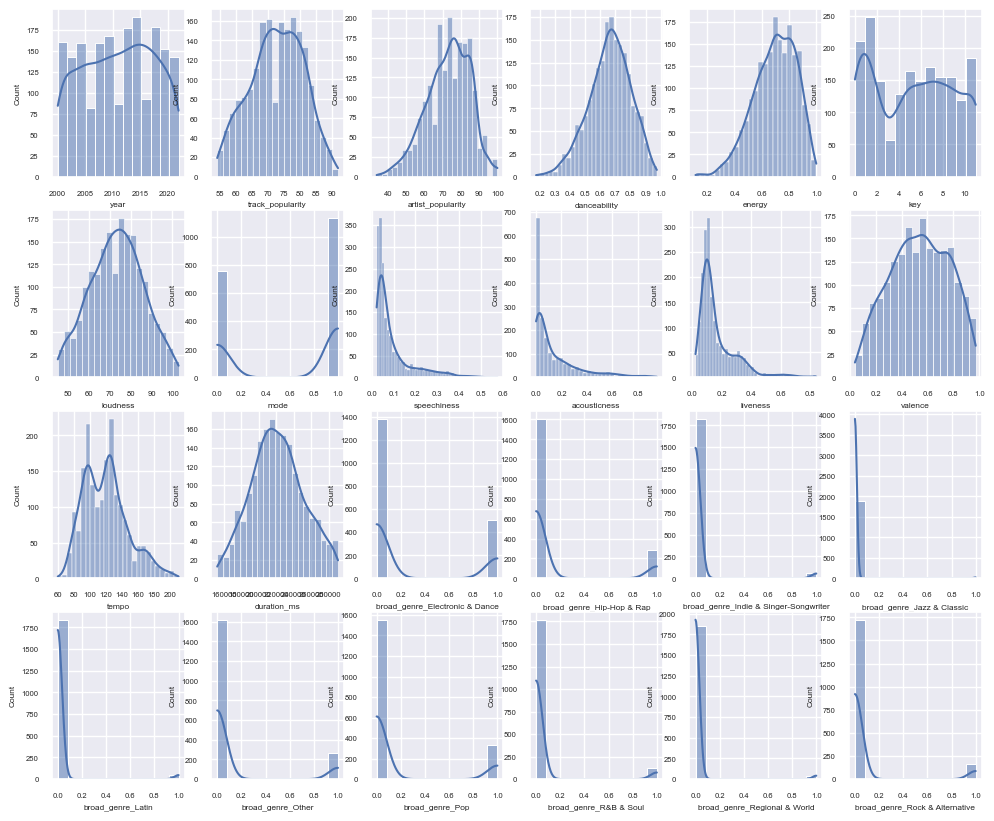

In [209]:
plot_ghraphs(data2,4,6,0.3)

Now let's apply some transformations

In [210]:
data3=data2.copy()

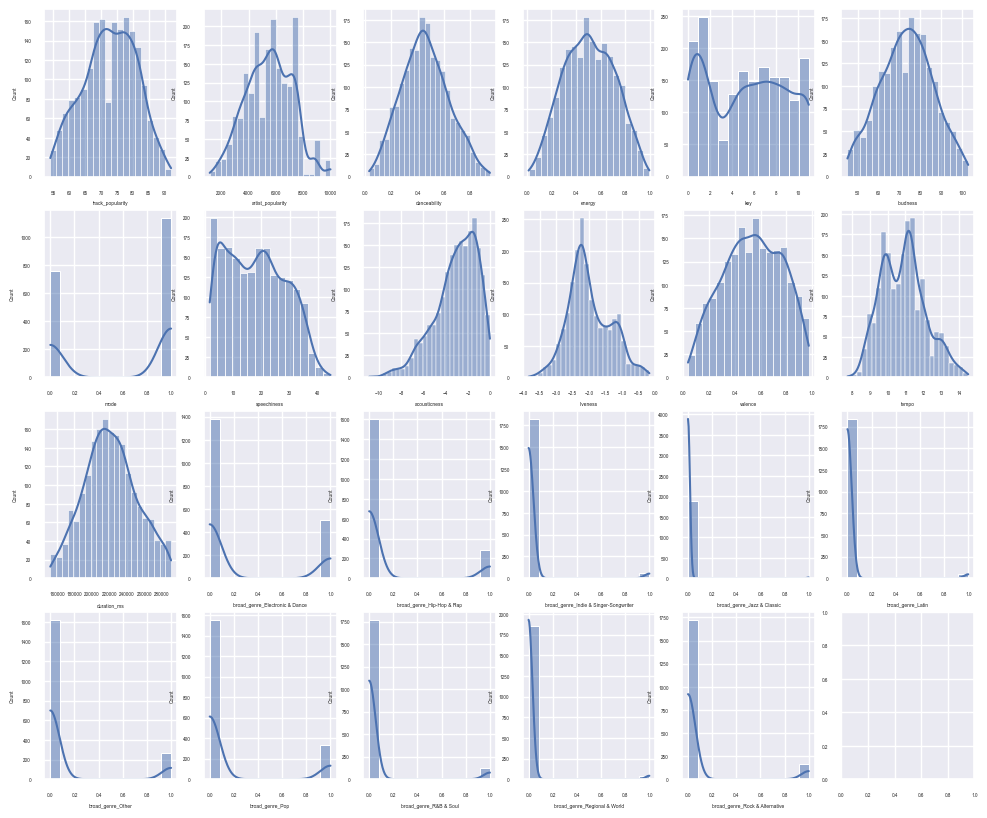

In [211]:
data3.drop('year', axis=1, inplace=True)
data3['artist_popularity']=data3['artist_popularity']**2
data3['danceability']=data3['danceability']**2
data3['energy']=data3['energy']**2
data3['speechiness']=1/data3['speechiness']
data3['acousticness']=np.log(data3['acousticness'])
data3['liveness']=np.log(data3['liveness'])
data3['tempo']=np.sqrt(data3['tempo'])

plot_ghraphs(data3,4,6, 0.3)

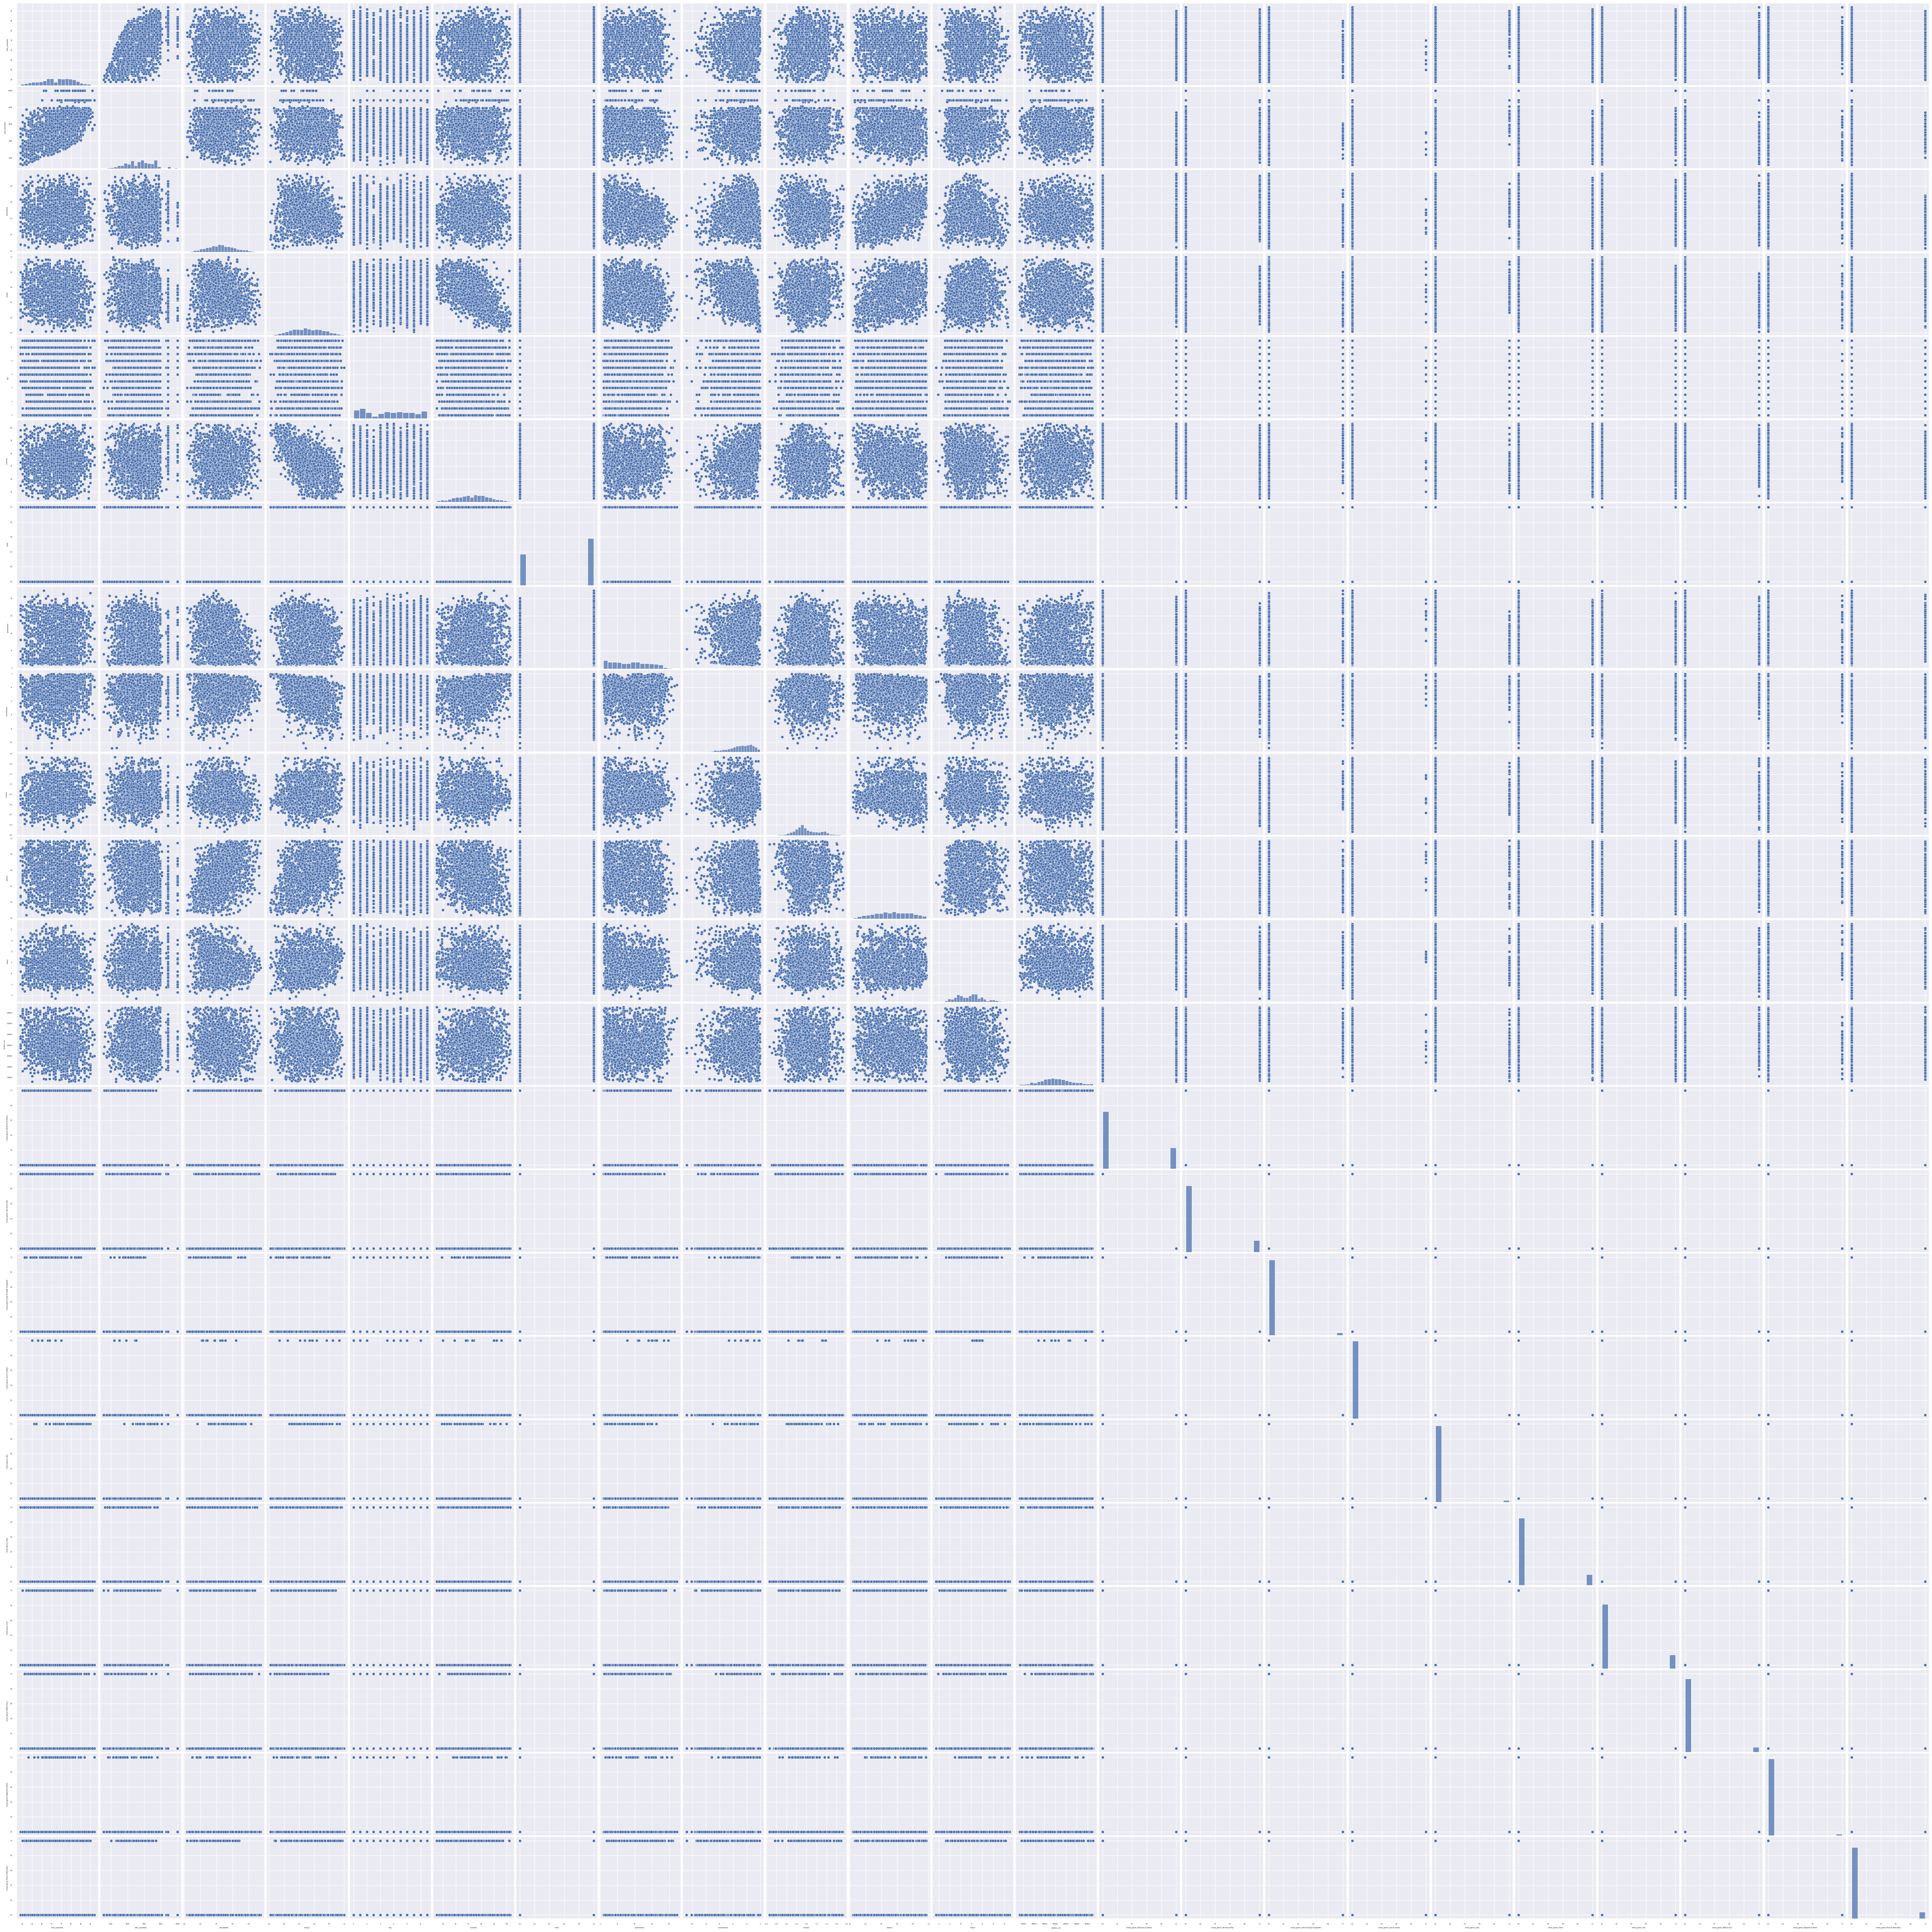

In [212]:
sns.pairplot(data3)

In [213]:
y=data3['track_popularity'].reset_index(drop=True)
X=data3.drop(['track_popularity'], axis=1).reset_index(drop=True)

<Axes: >

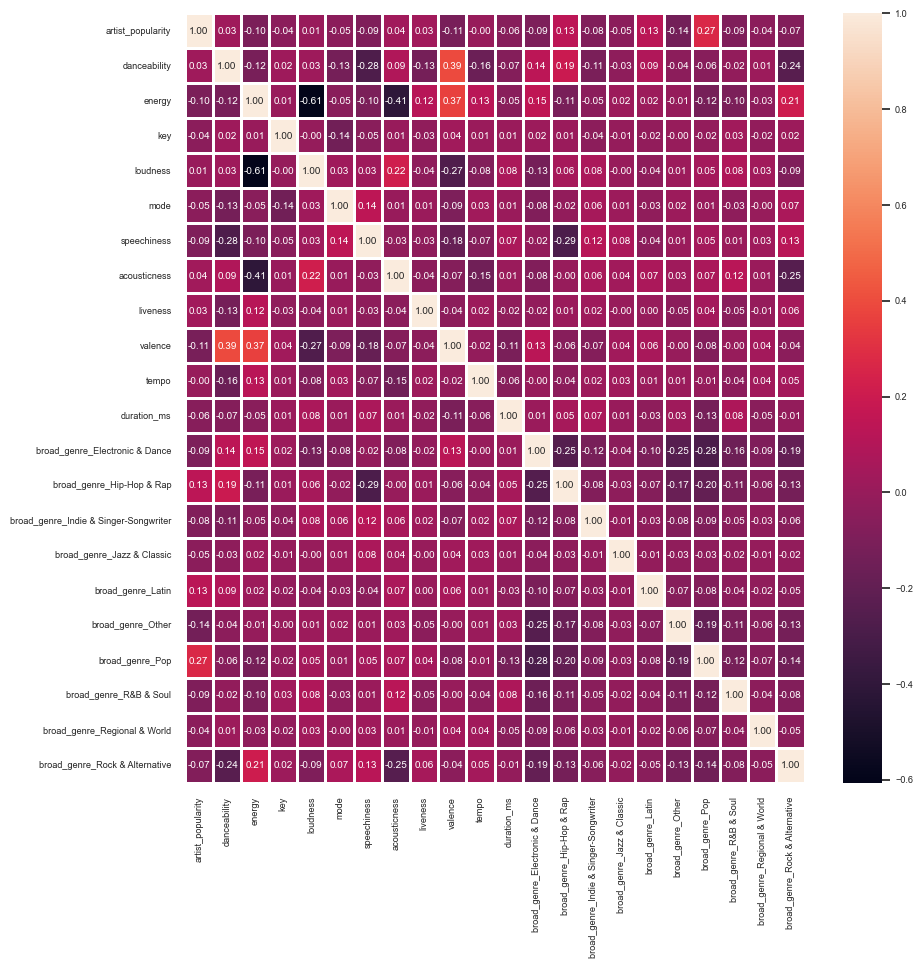

In [215]:
sns.set_theme(font_scale=0.6)
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(X.corr(),annot=True, fmt=".2f", linewidths=1, ax=ax)

Seems that Loudness and Energy have a high negative correlation (weird but ok). In that case, let's drop Energy which also has a relatively high negative correlation with acousticness

In [216]:
X=X.drop('energy', axis=1)

In [217]:
#Now let's create the scaler in order to standardize units

scaler=StandardScaler()

scaler.fit(X)

X_scaled=scaler.transform(X)

X_scaled

array([[-0.97950253, -0.13259168, -0.35219465, ...,  3.85558637,
        -0.14712247, -0.30842764],
       [-1.83873485, -1.27788534,  0.47075523, ..., -0.25936392,
        -0.14712247, -0.30842764],
       [ 0.17090415, -0.92567876, -1.17514453, ..., -0.25936392,
        -0.14712247, -0.30842764],
       ...,
       [ 0.6383313 , -0.53146904, -0.07787803, ..., -0.25936392,
        -0.14712247, -0.30842764],
       [ 1.13553088,  1.2484828 , -0.07787803, ..., -0.25936392,
        -0.14712247, -0.30842764],
       [ 1.23854348, -0.82003879, -1.17514453, ..., -0.25936392,
         6.79705819, -0.30842764]])

# **K-Means**

In [218]:
#Create the function to calculate silhouette score and plot elbow graph
def silhouette_elbow(data:pd.DataFrame, min_k:int, max_k:int):

    k=list(range(min_k, max_k))
    inertia=[]
    score=[]

    for i in k:
        kmeans=KMeans(n_clusters=i, random_state=30)

        kmeans.fit(data)
        labels = kmeans.predict(data)
        centroids = kmeans.cluster_centers_

        inertia.append(kmeans.inertia_)
        score.append("{:.3f}".format(silhouette_score(data, labels=labels)))

        print(f'Silhouette score for {i} clusters:',silhouette_score(data, labels=labels))

    plt.figure(figsize=(8, 6))
    plt.plot(k, inertia, marker='o')

    for i, txt in enumerate(score):
        plt.text(k[i]+0.05, inertia[i], f"{txt}", fontsize=10, ha='left', va='bottom')

    plt.title("Elbow method to select k")
    plt.xlabel("Number of clusters (k) with silhouette value in each")
    plt.ylabel("Inertia")
    plt.ylim(min(inertia) - 10, max(inertia) + 100)
    plt.xticks(k)
    plt.grid(True)
    plt.show()

Silhouette score for 2 clusters: 0.07681039339691229
Silhouette score for 3 clusters: 0.07303796806487013
Silhouette score for 4 clusters: 0.10594701340997123
Silhouette score for 5 clusters: 0.15107301058604336
Silhouette score for 6 clusters: 0.16563138674092995
Silhouette score for 7 clusters: 0.17673491240784936
Silhouette score for 8 clusters: 0.14133382170537756


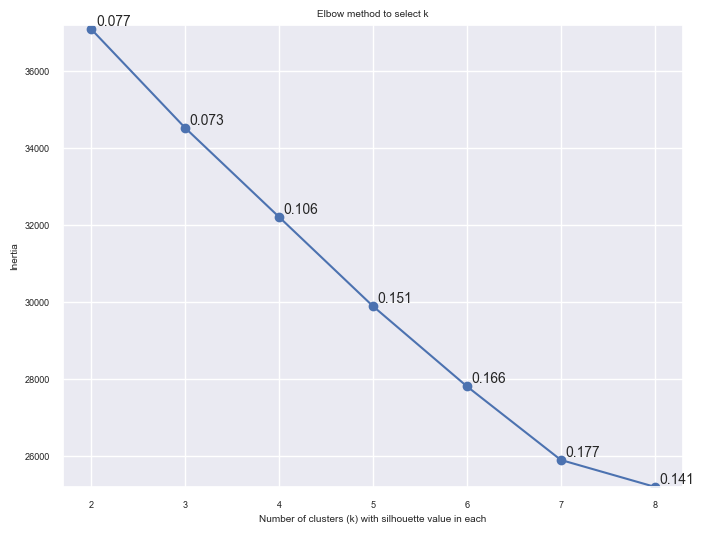

In [219]:
silhouette_elbow(X_scaled,2,9)

According to the analysis it seems that k=4 is the best option (although the values are quite bad)

In [220]:
#Run K-Means with the selected number of clusters

kmeans=KMeans(n_clusters=7, random_state=50)
kmeans.fit(X_scaled)

labels=kmeans.predict(X_scaled)
labels

array([5, 3, 4, ..., 3, 4, 4])

In [221]:
X.columns

Index(['artist_popularity', 'danceability', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'broad_genre_Electronic & Dance',
       'broad_genre_Hip-Hop & Rap', 'broad_genre_Indie & Singer-Songwriter',
       'broad_genre_Jazz & Classic', 'broad_genre_Latin', 'broad_genre_Other',
       'broad_genre_Pop', 'broad_genre_R&B & Soul',
       'broad_genre_Regional & World', 'broad_genre_Rock & Alternative'],
      dtype='object')

In [222]:
# Include the K-Means clusters in the data

X_clusters=pd.DataFrame(data=X_scaled, columns=X.columns)
X_clusters['Cluster']=labels

X_clusters

artist_popularity  danceability       key  loudness      mode  \
0             -0.979503     -0.132592 -0.352195  1.078549 -1.225015   
1             -1.838735     -1.277885  0.470755 -0.185351  0.816316   
2              0.170904     -0.925679 -1.175145  0.525593  0.816316   
3              0.080991     -1.520608 -1.449461 -0.343338  0.816316   
4             -1.333794     -0.807396 -1.175145  1.473518  0.816316   
...                 ...           ...       ...       ...       ...   
1883           1.342747     -1.373789 -1.175145 -0.659313  0.816316   
1884          -1.401080     -0.704629 -1.449461  1.552512 -1.225015   
1885           0.638331     -0.531469 -0.077878  0.209618  0.816316   
1886           1.135531      1.248483 -0.077878 -0.896295 -1.225015   
1887           1.238543     -0.820039 -1.175145 -0.659313  0.816316   

      speechiness  acousticness  liveness   valence     tempo  ...  \
0        0.242602      0.822242 -0.557921  1.543530 -1.435322  ...   
1       -0.280336     -2.055390 -0.577567  0.536382 -0.858802  ...   
2        1.496998      1.214144 -0.464797 -1.416072 -0.025640  ...   
3        0.238514     -0.787150  2.322533  0.642397  1.062365  ...   
4        1.246271      0.885770 -0.147386 -1.305639  0.761509  ...   
...           ...           ...       ...       ...       ...  ...   
1883    -1.466663      0.983554 -1.063270 -0.881577 -1.418675  ...   
1884    -0.587461      1.050057 -0.318733  1.287325  2.805654  ...   
1885     0.859343     -0.331837  2.247427  0.169744  1.009830  ...   
1886    -0.614744      0.329107 -0.237286  1.512608 -0.397895  ...   
1887    -1.238359     -0.044256  1.380964  0.637980  1.807960  ...   

      broad_genre_Hip-Hop & Rap  broad_genre_Indie & Singer-Songwriter  \
0                     -0.419909                              -0.190326   
1                     -0.419909                              -0.190326   
2                     -0.419909                              -0.190326   
3                     -0.419909                              -0.190326   
4                     -0.419909                              -0.190326   
...                         ...                                    ...   
1883                   2.381466                              -0.190326   
1884                  -0.419909                              -0.190326   
1885                  -0.419909                              -0.190326   
1886                  -0.419909                              -0.190326   
1887                  -0.419909                              -0.190326   

      broad_genre_Jazz & Classic  broad_genre_Latin  broad_genre_Other  \
0                      -0.072971          -0.164935          -0.405849   
1                      -0.072971          -0.164935          -0.405849   
2                      -0.072971          -0.164935          -0.405849   
3                      -0.072971          -0.164935          -0.405849   
4                      -0.072971          -0.164935          -0.405849   
...                          ...                ...                ...   
1883                   -0.072971          -0.164935          -0.405849   
1884                   -0.072971          -0.164935          -0.405849   
1885                   -0.072971          -0.164935          -0.405849   
1886                   -0.072971          -0.164935          -0.405849   
1887                   -0.072971          -0.164935          -0.405849   

      broad_genre_Pop  broad_genre_R&B & Soul  broad_genre_Regional & World  \
0           -0.464448                3.855586                     -0.147122   
1            2.153096               -0.259364                     -0.147122   
2           -0.464448               -0.259364                     -0.147122   
3           -0.464448               -0.259364                     -0.147122   
4           -0.464448               -0.259364                     -0.147122   
...               ...                     ...               

In [223]:
# Visualize the clusters metrics

by_cluster=X_clusters.groupby('Cluster', as_index=True).mean()
by_cluster

artist_popularity  danceability       key  loudness      mode  \
Cluster                                                                  
0                -0.427404     -0.560405 -0.210880  0.395134  0.290519   
1                 0.320740      0.453997  0.025839  0.132578 -0.042053   
2                -0.336585     -0.098079 -0.002878  0.035358  0.044127   
3                 0.577785     -0.123156 -0.043690  0.119607  0.016744   
4                -0.134291      0.173540 -0.004671 -0.161362 -0.072853   
5                -0.339040     -0.079281  0.127283  0.322466 -0.127156   
6                -0.240870     -0.777547  0.060953 -0.283611  0.231301   

         speechiness  acousticness  liveness   valence     tempo  ...  \
Cluster                                                           ...   
0           0.631780      0.319309  0.127905 -0.363847  0.095932  ...   
1          -0.683715     -0.007161  0.022251 -0.133870 -0.089012  ...   
2           0.033807      0.073717 -0.116026 -0.008477  0.025127  ...   
3           0.110472      0.154006  0.090924 -0.166885 -0.032826  ...   
4           0.052502     -0.023781 -0.033299  0.220311  0.026756  ...   
5           0.037521      0.476259 -0.194931 -0.004056 -0.161935  ...   
6           0.407574     -0.803659  0.186015 -0.138765  0.152668  ...   

         broad_genre_Electronic & Dance  broad_genre_Hip-Hop & Rap  \
Cluster                                                              
0                             -0.606726                  -0.419909   
1                             -0.606726                   2.381466   
2                             -0.606726                  -0.419909   
3                             -0.606726                  -0.419909   
4                              1.150173                  -0.419909   
5                             -0.606726                  -0.419909   
6                             -0.606726                  -0.419909   

         broad_genre_Indie & Singer-Songwriter  broad_genre_Jazz & Classic  \
Cluster                                                                      
0                                     5.254147                   -0.072971   
1                                    -0.190326                   -0.072971   
2                                    -0.190326                   -0.072971   
3                                    -0.190326                   -0.072971   
4                                    -0.190326                    0.138332   
5                                    -0.190326                   -0.072971   
6                                    -0.190326                   -0.072971   

         broad_genre_Latin  broad_genre_Other  broad_genre_Pop  \
Cluster                                                          
0                -0.164935          -0.405849        -0.464448   
1                -0.164935          -0.405849        -0.464448   
2                -0.164935           2.463973        -0.464448   
3                -0.164935          -0.405849         2.137561   
4                 0.312668          -0.405849        -0.464448   
5                -0.164935          -0.405849        -0.464448   
6                -0.164935          -0.405849        -0.464448   

         broad_genre_R&B & Soul  broad_genre_Regional & World  \
Cluster                                                         
0                     -0.259364                     -0.147122   
1                     -0.259364                     -0.147122   
2                     -0.259364                     -0.147122   
3                     -0.259364                     -0.147122   
4                     -0.259364                      0.278901   
5                      3.855586                     -0.147122   
6                     -0.259364                     -0.147122   

         broad_genre_Rock & Alternative  
Cluster                                  
0                             -0.308428  
1                             -0.308428  
2

<Axes: xlabel='Cluster'>

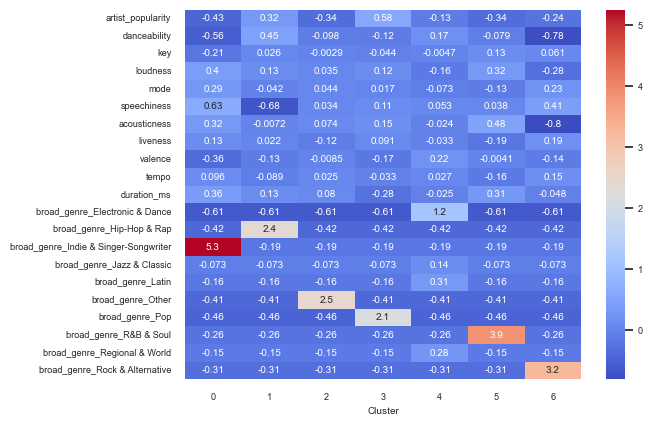

In [224]:
sns.heatmap(by_cluster.T,cmap="coolwarm", annot=True, cbar=True)

In [225]:
merged_ds=X_clusters.copy()
merged_ds['track_popularity']=y

merged_ds.groupby('Cluster',as_index=True)['track_popularity'].mean().T
#sns.heatmap(merged_ds.groupby('Cluster',as_index=True)['track_popularity'].mean().T,cmap="coolwarm", annot=True, cbar=True)

Cluster
0    71.984848
1    73.731449
2    70.662921
3    75.599407
4    71.513804
5    71.084034
6    74.682927
Name: track_popularity, dtype: float64

**Let's try gaussian mixture now**

In [226]:
gm=GaussianMixture(n_components=7)

gmlab=gm.fit_predict(X_scaled)

gmlab

array([5, 3, 2, ..., 3, 2, 2], dtype=int64)

In [227]:
# Include the K-Means clusters in the data

X_clusters_gm=pd.DataFrame(data=X_scaled, columns=X.columns)
X_clusters_gm['Cluster']=gmlab

X_clusters_gm

artist_popularity  danceability       key  loudness      mode  \
0             -0.979503     -0.132592 -0.352195  1.078549 -1.225015   
1             -1.838735     -1.277885  0.470755 -0.185351  0.816316   
2              0.170904     -0.925679 -1.175145  0.525593  0.816316   
3              0.080991     -1.520608 -1.449461 -0.343338  0.816316   
4             -1.333794     -0.807396 -1.175145  1.473518  0.816316   
...                 ...           ...       ...       ...       ...   
1883           1.342747     -1.373789 -1.175145 -0.659313  0.816316   
1884          -1.401080     -0.704629 -1.449461  1.552512 -1.225015   
1885           0.638331     -0.531469 -0.077878  0.209618  0.816316   
1886           1.135531      1.248483 -0.077878 -0.896295 -1.225015   
1887           1.238543     -0.820039 -1.175145 -0.659313  0.816316   

      speechiness  acousticness  liveness   valence     tempo  ...  \
0        0.242602      0.822242 -0.557921  1.543530 -1.435322  ...   
1       -0.280336     -2.055390 -0.577567  0.536382 -0.858802  ...   
2        1.496998      1.214144 -0.464797 -1.416072 -0.025640  ...   
3        0.238514     -0.787150  2.322533  0.642397  1.062365  ...   
4        1.246271      0.885770 -0.147386 -1.305639  0.761509  ...   
...           ...           ...       ...       ...       ...  ...   
1883    -1.466663      0.983554 -1.063270 -0.881577 -1.418675  ...   
1884    -0.587461      1.050057 -0.318733  1.287325  2.805654  ...   
1885     0.859343     -0.331837  2.247427  0.169744  1.009830  ...   
1886    -0.614744      0.329107 -0.237286  1.512608 -0.397895  ...   
1887    -1.238359     -0.044256  1.380964  0.637980  1.807960  ...   

      broad_genre_Hip-Hop & Rap  broad_genre_Indie & Singer-Songwriter  \
0                     -0.419909                              -0.190326   
1                     -0.419909                              -0.190326   
2                     -0.419909                              -0.190326   
3                     -0.419909                              -0.190326   
4                     -0.419909                              -0.190326   
...                         ...                                    ...   
1883                   2.381466                              -0.190326   
1884                  -0.419909                              -0.190326   
1885                  -0.419909                              -0.190326   
1886                  -0.419909                              -0.190326   
1887                  -0.419909                              -0.190326   

      broad_genre_Jazz & Classic  broad_genre_Latin  broad_genre_Other  \
0                      -0.072971          -0.164935          -0.405849   
1                      -0.072971          -0.164935          -0.405849   
2                      -0.072971          -0.164935          -0.405849   
3                      -0.072971          -0.164935          -0.405849   
4                      -0.072971          -0.164935          -0.405849   
...                          ...                ...                ...   
1883                   -0.072971          -0.164935          -0.405849   
1884                   -0.072971          -0.164935          -0.405849   
1885                   -0.072971          -0.164935          -0.405849   
1886                   -0.072971          -0.164935          -0.405849   
1887                   -0.072971          -0.164935          -0.405849   

      broad_genre_Pop  broad_genre_R&B & Soul  broad_genre_Regional & World  \
0           -0.464448                3.855586                     -0.147122   
1            2.153096               -0.259364                     -0.147122   
2           -0.464448               -0.259364                     -0.147122   
3           -0.464448               -0.259364                     -0.147122   
4           -0.464448               -0.259364                     -0.147122   
...               ...                     ...               

In [228]:
# Visualize the clusters metrics

by_cluster_gm=X_clusters_gm.groupby('Cluster', as_index=True).mean()
by_cluster_gm

artist_popularity  danceability       key  loudness      mode  \
Cluster                                                                  
0                -0.240870     -0.777547  0.060953 -0.283611  0.231301   
1                -0.336585     -0.098079 -0.002878  0.035358  0.044127   
2                -0.209893      0.141318  0.000693 -0.150955 -0.062403   
3                 0.607614     -0.035615 -0.047240  0.068250 -0.010821   
4                -0.427404     -0.560405 -0.210880  0.395134  0.290519   
5                -0.339040     -0.079281  0.127283  0.322466 -0.127156   
6                 0.320740      0.453997  0.025839  0.132578 -0.042053   

         speechiness  acousticness  liveness   valence     tempo  ...  \
Cluster                                                           ...   
0           0.407574     -0.803659  0.186015 -0.138765  0.152668  ...   
1           0.033807      0.073717 -0.116026 -0.008477  0.025127  ...   
2           0.083430     -0.057987 -0.038425  0.203289  0.018563  ...   
3           0.054723      0.185504  0.083479 -0.091906 -0.012544  ...   
4           0.631780      0.319309  0.127905 -0.363847  0.095932  ...   
5           0.037521      0.476259 -0.194931 -0.004056 -0.161935  ...   
6          -0.683715     -0.007161  0.022251 -0.133870 -0.089012  ...   

         broad_genre_Electronic & Dance  broad_genre_Hip-Hop & Rap  \
Cluster                                                              
0                             -0.606726                  -0.419909   
1                             -0.606726                  -0.419909   
2                              1.289794                  -0.419909   
3                             -0.606726                  -0.419909   
4                             -0.606726                  -0.419909   
5                             -0.606726                  -0.419909   
6                             -0.606726                   2.381466   

         broad_genre_Indie & Singer-Songwriter  broad_genre_Jazz & Classic  \
Cluster                                                                      
0                                    -0.190326                   -0.072971   
1                                    -0.190326                   -0.072971   
2                                    -0.190326                    0.155124   
3                                    -0.190326                   -0.072971   
4                                     5.254147                   -0.072971   
5                                    -0.190326                   -0.072971   
6                                    -0.190326                   -0.072971   

         broad_genre_Latin  broad_genre_Other  broad_genre_Pop  \
Cluster                                                          
0                -0.164935          -0.405849        -0.464448   
1                -0.164935           2.463973        -0.464448   
2                -0.164935          -0.405849        -0.464448   
3                 0.643888          -0.405849         1.813155   
4                -0.164935          -0.405849        -0.464448   
5                -0.164935          -0.405849        -0.464448   
6                -0.164935          -0.405849        -0.464448   

         broad_genre_R&B & Soul  broad_genre_Regional & World  \
Cluster                                                         
0                     -0.259364                     -0.147122   
1                     -0.259364                     -0.147122   
2                     -0.259364                      0.312757   
3                     -0.259364                     -0.147122   
4                     -0.259364                     -0.147122   
5                      3.855586                     -0.147122   
6                     -0.259364                     -0.147122   

         broad_genre_Rock & Alternative  
Cluster                                  
0                              3.242252  
1                             -0.308428  
2

<Axes: xlabel='Cluster'>

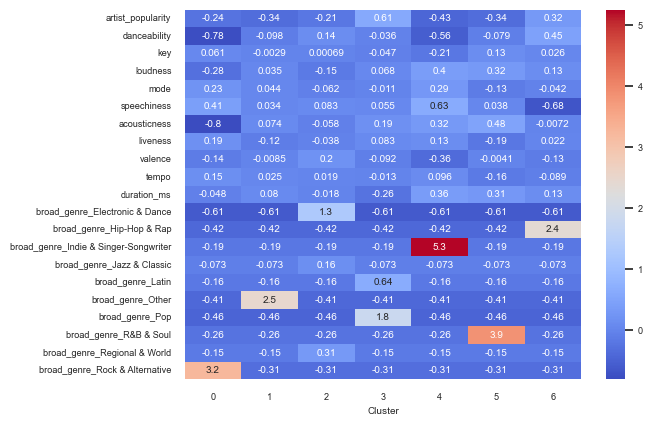

In [229]:
sns.heatmap(by_cluster_gm.T,cmap="coolwarm", annot=True, cbar=True)

In [230]:
merged_ds_gm=X_clusters_gm.copy()
merged_ds_gm['track_popularity']=y

merged_ds_gm.groupby('Cluster',as_index=True)['track_popularity'].mean().T
#sns.heatmap(merged_ds.groupby('Cluster',as_index=True)['track_popularity'].mean().T,cmap="coolwarm", annot=True, cbar=True)

Cluster
0    74.682927
1    70.662921
2    70.951987
3    75.971429
4    71.984848
5    71.084034
6    73.731449
Name: track_popularity, dtype: float64

**From the K-Means and Gaussian Mixture Analyses it seems that there's not much difference in results, so we will proceed with these clusters**

It looks like the clustering doesn't affect at all the popularity of a song. In this sense, we will proceed with Lineaar regression for the whole dataset.

# **Regression**

In [231]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [232]:
def get_linreg_data(y, X):
    '''
    Returns the reserved data and the test and train data for the model once processed with the stepwise function to only include
    relevant variables.

    Parameters
    ----------
    y: Matrix or Series of target values for the linear regression (dependent variable)

    X: Matrix of independent variables (Exogenous, Predictors)

    Returns
    -------
    X_reserved
    y_reserved
    X_train
    y_train
    X_test
    y_test

    All after filtering the Stepwise results to only include relevant columns
    '''
    
    
    data_model, data_reserved = train_test_split(pd.concat([y,X], axis=1), test_size=0.1, random_state=42)

    X_reserved=data_reserved.drop(y.name, axis=1)
    y_reserved=data_reserved[y.name]

    X_lr=data_model.drop(y.name, axis=1)
    y_lr=data_model[y.name]

    X_train, X_test, y_train, y_test= train_test_split(X_lr, y_lr, test_size=0.3, random_state=95)

    stepwise=stepwise_selection(X_train, y_train,verbose=False)

    X_reserved, X_train, X_test = X_reserved[stepwise], X_train[stepwise], X_test[stepwise]

    print ("Sample size dataset reserved for prediction: ", data_reserved.shape[0], "records")
    print ("Sample size train dataset: ", X_train.shape)
    print ("Sample size test dataset: ", X_test.shape)

    return X_reserved, y_reserved, X_train, y_train, X_test, y_test
    

In [233]:
X_reserved, y_reserved, X_train, y_train, X_test, y_test=get_linreg_data(y,X)

Sample size dataset reserved for prediction:  189 records
Sample size train dataset:  (1189, 5)
Sample size test dataset:  (510, 5)


In [234]:
#Define the linear regression

lm=LinearRegression()

model=lm.fit(X_train,y_train)

model.score(X_train, y_train)

0.29509630843737056

In [235]:
def adj_r2(X,y,r2):
    '''Returns the adjusted coefficient of determination of the prediction.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples. For some estimators this may be a precomputed
            kernel matrix or a list of generic objects instead with shape
            ``(n_samples, n_samples_fitted)``, where ``n_samples_fitted``
            is the number of samples used in the fitting for the estimator.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True values for `X`.

        r2 : R^2 score of the Linear Regression Model

        Returns
        -------
        score : float
            :math:`ADJ_R^2` of ``self.predict(X)`` w.r.t. `y`.'''
    
    n=X.shape[0]
    p=X.shape[1]

    return 1-(((1-r2)*(n-1))/(n-p-1))

        

In [236]:
adj_r2(X_train,y_train,model.score(X_train, y_train))

0.2921170028939951

In [237]:
# print coefficients (but not confidence intervals: sklearn does not store them)
coeff_df = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
print("Intercept: ", model.intercept_)
coeff_df

Intercept:  68.92276948013436


Coefficient
artist_popularity                  0.002436
duration_ms                       -0.000038
broad_genre_Electronic & Dance    -1.443325
broad_genre_Rock & Alternative     3.225971
acousticness                       0.378787

In [238]:
X_train_sm=sm.add_constant(X_train)

result = sm.OLS(y_train, X_train_sm).fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     99.05
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           2.58e-87
Time:                        13:01:04   Log-Likelihood:                -4005.0
No. Observations:                1189   AIC:                             8022.
Df Residuals:                    1183   BIC:                             8053.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

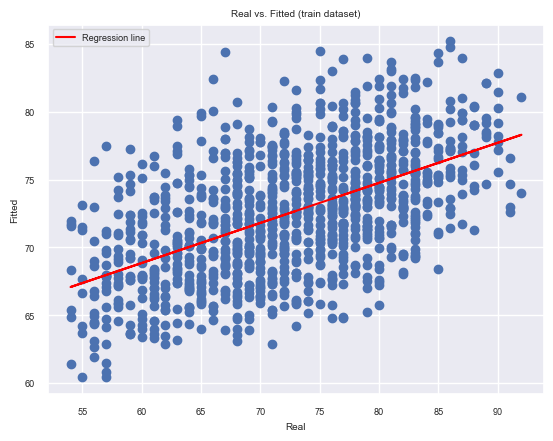

In [239]:
y_train_hat=model.predict(X_train)

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,y_train_hat)

coef = np.polyfit(y_train, y_train_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

Adjusted R2 for the testing set: 0.2824955707983673


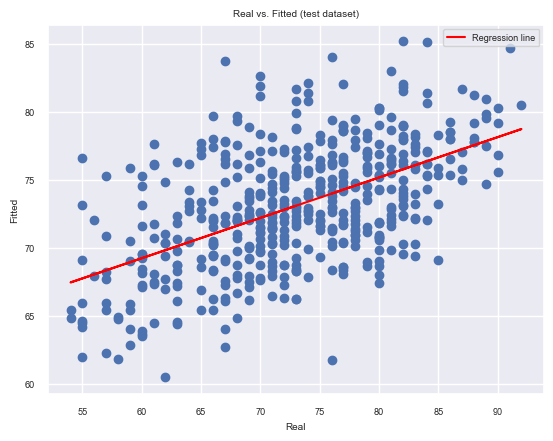

In [240]:
y_test_hat=model.predict(X_test)

print(f'Adjusted R2 for the testing set: {adj_r2(X_test,y_test,r2_score(y_test, y_test_hat))}')

plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,y_test_hat)

coef = np.polyfit(y_test, y_test_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()


# **Random Forest**

In [241]:
#Run Random Forest to try and improve the accuracy

from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(n_estimators=50,min_samples_leaf=15, min_samples_split=20, max_depth=5)
rf.fit(X_train,y_train)

print(rf.score(X_train, y_train))

rf_y_test_hat=rf.predict(X_test)

print(f'RF R2 for the testing set: {r2_score(y_test, rf_y_test_hat)}')

0.37287830709681935
RF R2 for the testing set: 0.30175329569458387


RF R2 for the training set: 0.37287830709681935


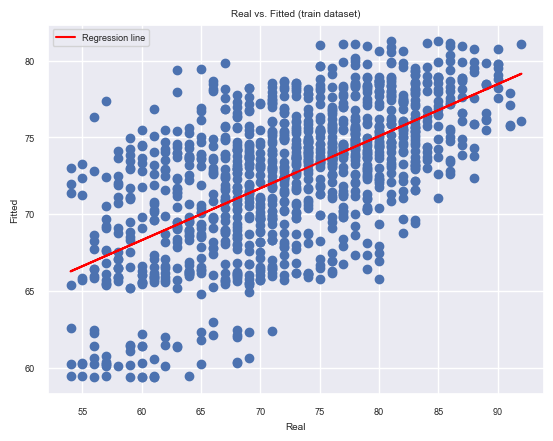

In [242]:
rf_y_hat=rf.predict(X_train)

print(f'RF R2 for the training set: {r2_score(y_train, rf_y_hat)}')

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,rf_y_hat)

coef = np.polyfit(y_train,rf_y_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

RF R2 for the testing set: 0.30175329569458387


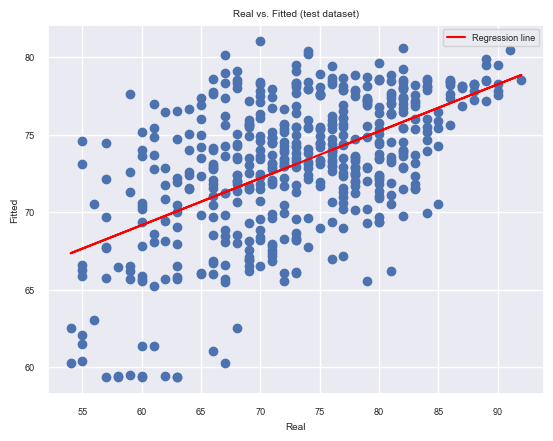

In [243]:
rf_y_test_hat=rf.predict(X_test)

print(f'RF R2 for the testing set: {r2_score(y_test, rf_y_test_hat)}')

plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,rf_y_test_hat)

coef = np.polyfit(y_test,rf_y_test_hat, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

Even with Random Forest, the performance of the model is very poor in the testing set, plus we can see it is overfitted. According to all the analyses done, we can inferr that there must be missing variables in the set that can help us both segment and predict with higher performance.